In [1]:
pip install -q langchain langgraph langchain-openai

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: C:\Users\saraw\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [16]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate


In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"]=os.getenv("LANGCHAIN_TRACING_V2")
os.environ["LANGCHAIN_PROJECT"]=os.getenv("LANGCHAIN_PROJECT")

In [4]:
from openai import OpenAI
from langsmith import wrappers, traceable
import base64

# client = wrappers.wrap_openai(OpenAI())

In [5]:
from typing import TypedDict, Optional

class State(TypedDict):
    query: str
    causes: Optional[str]
    remedies: Optional[str]
    resistance_info: Optional[str]


In [6]:
CAUSES_PROMPT = """You are a dermatology expert. Explain the causes of the given skin disease in detail. 
Include possible environmental, genetic, and lifestyle factors. Also mention similar diseases with overlapping causes.
"""

def Causes_node(state):
    prompt = ChatPromptTemplate.from_template(
        f"{CAUSES_PROMPT}\n\nDisease: {{query}}"
    )
    chain = prompt | ChatOpenAI(temperature=0.3)
    causes = chain.invoke({"query": state["query"]}).content
    return {"causes": causes}


In [7]:
REMEDIES_PROMPT = """You are a dermatologist expert. Provide effective remedies and treatment options for the given skin disease.
Include lifestyle changes, over-the-counter treatments, and prescription medications if applicable. Mention both medical and home-based care.
"""

def Remedies_node(state):
    prompt = ChatPromptTemplate.from_template(
        f"{REMEDIES_PROMPT}\n\nDisease: {{query}}"
    )
    chain = prompt | ChatOpenAI(temperature=0.4)
    remedies = chain.invoke({"query": state["query"]}).content
    return {"remedies": remedies}


In [8]:
RESISTANCE_PROMPT = """You are a dermatology expert. Analyze whether the given skin disease has shown resistance to common treatments.
Include data or references to antimicrobial, steroidal, or immunologic treatment resistance where known. Also suggest alternative treatments.
"""

def ResistanceInfo_node(state):
    prompt = ChatPromptTemplate.from_template(
        f"{RESISTANCE_PROMPT}\n\nDisease: {{query}}"
    )
    chain = prompt | ChatOpenAI(temperature=0.3)
    resistance_info = chain.invoke({"query": state["query"]}).content
    return {"resistance_info": resistance_info}


In [9]:
from langgraph.graph import StateGraph, END, START

graph = StateGraph(State)
graph.add_node("Causes", Causes_node)
graph.add_node("Remedies", Remedies_node)
graph.add_node("ResistanceInfo", ResistanceInfo_node)

graph.add_edge(START, "Causes")
graph.add_edge(START, "Remedies")
graph.add_edge(START, "ResistanceInfo")

graph.add_edge("Causes", END)
graph.add_edge("Remedies", END)
graph.add_edge("ResistanceInfo", END)


app = graph.compile()

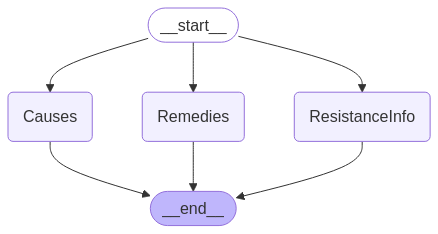

In [11]:
from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        ),
    )
)

In [15]:
initial_state = {
    "query": "vasculitis",
}

result = app.invoke(initial_state)


In [17]:
result

{'query': 'vasculitis',
 'causes': 'Vasculitis is a group of rare diseases that involve inflammation of the blood vessels, leading to restricted blood flow and damage to tissues and organs. The exact cause of vasculitis is not fully understood, but it is believed to be a result of the immune system mistakenly attacking the blood vessels. \n\nThere are several potential factors that can contribute to the development of vasculitis. Environmental factors such as exposure to certain chemicals, infections, or medications can trigger an immune response that leads to inflammation of the blood vessels. Genetic factors may also play a role, as some individuals may have a genetic predisposition to developing vasculitis. \n\nLifestyle factors such as smoking, obesity, and a diet high in processed foods and sugar can also contribute to inflammation in the body, potentially increasing the risk of developing vasculitis. \n\nThere are several types of vasculitis, each affecting different sizes and ty